# Урок 9. Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

Критерии оценивания:
1 - Слушатель проанализировал результат эксперимента

In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_1samp
import numpy as np
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

# Загрузим данные

In [2]:
data = pd.read_csv('C:/Users/Jess/Downloads/результаты А_B - cookie_cats 2.csv')

data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


# Посмотрим на типы данных и есть ли NULL значения


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


# Посмотрим на количество уникальных пользователей в каждой группе

In [6]:
data.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


# Посмотрим на общий retantion rate

In [10]:
data_retention = data[["retention_1","retention_7"]].mean()*100
print(f"1-день retention ratio: {round(data_retention[0],2)}% \
      \n7-день retention ratio: {round(data_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


# Посчитаем 1 день и 7-дней retention для обеих групп

In [12]:
data_retention_ab = data.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
data_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


В группе gate_30 больше игровых раундов и на 1.2% выше retantion rate на 7 день

In [13]:
ttest_ind(data[data.version == 'gate_30'].sum_gamerounds,
          data[data.version == 'gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)

# Используем бутстреп

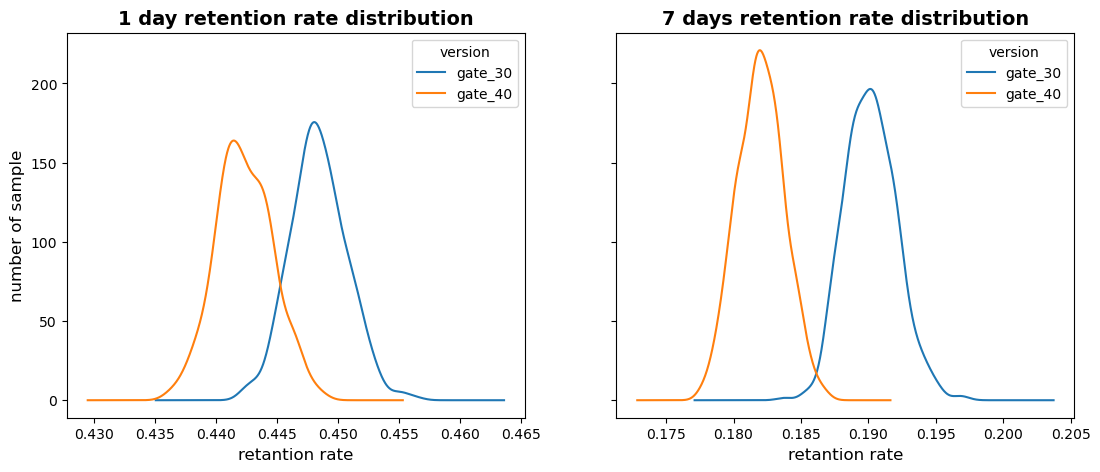

In [17]:
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

С помощью графика мы видим небольшую разницу 

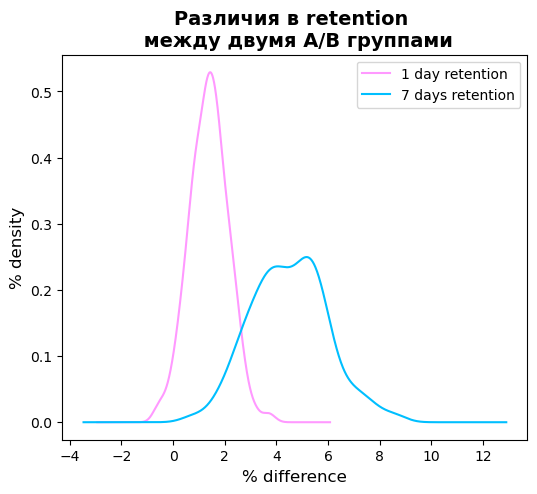

In [18]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)


fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Различия в retention \n между двумя A/B группами", fontweight="bold", size=14)
plt.legend()
plt.show()

В результате анализа можно сказать, что по метрике retantion rate 1 и 7 дней не следует перемещать ворота на 40 уровень, соответственно контрольная gate_30 показывает лучшие резуль